In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import TruncatedSVD
from scipy.spatial import distance
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.utils import plot_model
from scipy.spatial.distance import cdist, cosine
import matplotlib.pyplot as plt
from tensorboard.plugins import projector
import joblib
pd.set_option('display.max_columns', None)

2023-02-12 15:47:29.184953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 15:47:29.363472: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-12 15:47:30.245944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-12 15:47:30.246123: W tensorfl

In [ ]:
player_embedding = pd.read_csv('player_embedding.csv').drop(['Unnamed: 0'], axis=1).iloc[:,3:]
df = pd.read_csv('final_data/fifa_cleaned_all_columns.csv').drop(['Unnamed: 0'], axis=1)
player_details = df[['club_name','short_name','overall','season']]

In [ ]:
def get_position(club_pos):
    pos = club_pos.split(",")[0]
    return pos
position = df.apply(lambda x: get_position(x['player_positions']), axis=1)
position

0          CF
1          LW
2          RM
3          ST
4          CM
         ... 
126283    CDM
126284     CM
126285     CM
126286     ST
126287    CAM
Length: 126288, dtype: object

In [ ]:
player_embedding

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,3.265667,0.757148,1.709361,0.0,1.870791,0.000000,0.0,0.0,0.932092,0.0,1.050203,0.779398,0.0,0.0,3.547777,2.535839,0.914676,1.284182,1.337910,1.294660
1,3.758625,1.209742,1.564240,0.0,0.474581,0.460083,0.0,0.0,0.521481,0.0,1.467055,0.986364,0.0,0.0,2.773616,2.456737,0.486339,0.508786,0.510534,1.164134
2,2.898894,1.266350,1.875545,0.0,1.957869,0.040286,0.0,0.0,0.886252,0.0,0.966359,0.767043,0.0,0.0,3.300267,2.276494,1.297398,0.690070,0.657781,1.098054
3,3.622704,1.384349,1.968731,0.0,0.689646,0.611457,0.0,0.0,0.577605,0.0,0.934327,0.825177,0.0,0.0,2.274490,1.901708,0.385015,1.425968,0.401931,0.913824
4,2.284001,1.387072,2.395956,0.0,1.186806,0.054275,0.0,0.0,1.419867,0.0,0.816368,1.042094,0.0,0.0,2.159883,2.955362,0.189032,0.535729,0.991364,1.050213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126283,0.463187,0.528406,0.896661,0.0,0.989502,1.371228,0.0,0.0,0.669588,0.0,0.600177,0.927473,0.0,0.0,0.705462,1.019581,0.764323,0.865071,0.617943,0.469705
126284,0.459426,0.739470,0.860212,0.0,0.998605,1.291639,0.0,0.0,0.672569,0.0,0.471460,0.524431,0.0,0.0,0.756158,1.039984,0.670674,0.754113,0.496114,0.379089
126285,0.583554,0.534359,0.883899,0.0,1.025931,1.386753,0.0,0.0,0.701014,0.0,0.592992,0.746789,0.0,0.0,0.712209,0.987118,0.721504,1.002327,0.550613,0.527887
126286,0.524298,0.523198,0.106561,0.0,1.139934,1.555437,0.0,0.0,0.601059,0.0,0.505016,0.555318,0.0,0.0,1.317611,0.408143,0.491084,1.087960,0.779156,0.582550


In [ ]:
#Combined player position in cell 6, player details in cell 18, and player embedding into one df
#Create a key for each row using club_name and season for team embedding

player_embedding_combined = pd.concat([player_details, position.rename('best_pos'), player_embedding], axis=1)
player_embedding_combined['key'] = player_embedding_combined['club_name'].astype(str) + player_embedding_combined['season'].astype(str)
player_embedding_combined = player_embedding_combined.sort_values(by=['overall'], ascending=False)

#Create a column to classify players into defenders and non-defenders based on position
#Create a key for each row using club_name, season, and position classification for team embedding
def determine_defender(position):
    if ((position == 'LWB') or (position == 'LB') or (position == 'LCB') or (position == 'CB') or (position == 'RCB') or (position == 'RB') or (position == 'RWB')):
        return "D"
    else:
        return "ND"
player_embedding_combined['defender'] = player_embedding_combined.apply(lambda x: determine_defender(x['best_pos']), axis=1)
player_embedding_combined['player_key'] = player_embedding_combined['key'].astype(str) + player_embedding_combined['defender'].astype(str)
player_embedding_combined.head()

,club_name,short_name,overall,season,best_pos,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,key,defender,player_key
43907,Real Madrid CF,Cristiano Ronaldo,94,1718,LW,4.122661,1.222620,1.456111,0.0,0.988493,0.391356,0.0,0.0,0.691294,0.0,1.382363,1.027919,0.0,0.0,2.423369,2.852642,0.299847,0.576179,0.748574,1.174775,Real Madrid CF1718,ND,Real Madrid CF1718ND
59842,Juventus,Cristiano Ronaldo,94,1819,ST,4.006461,1.190789,1.405771,0.0,0.936381,0.394350,0.0,0.0,0.542199,0.0,1.362876,1.074068,0.0,0.0,2.313507,2.750958,0.377921,0.566794,0.707652,1.149878,Juventus1819,ND,Juventus1819ND
59843,FC Barcelona,L. Messi,94,1819,CF,3.385196,0.747430,2.103769,0.0,2.436939,0.000000,0.0,0.0,0.891759,0.0,1.049339,0.969589,0.0,0.0,3.431670,2.777207,0.796833,1.467861,1.355075,1.453514,FC Barcelona1819,ND,FC Barcelona1819ND
14380,FC Barcelona,L. Messi,94,1516,RW,3.246406,0.807521,1.621410,0.0,2.192120,0.000000,0.0,0.0,1.037212,0.0,1.100798,0.843648,0.0,0.0,3.447260,2.568624,0.887763,1.365363,1.271545,1.224468,FC Barcelona1516,ND,FC Barcelona1516ND
28304,Real Madrid CF,Cristiano Ronaldo,94,1617,LW,4.126410,1.259415,1.360926,0.0,0.948438,0.404244,0.0,0.0,0.702670,0.0,1.478321,1.046704,0.0,0.0,2.421443,2.830358,0.374458,0.605529,0.769751,1.149873,Real Madrid CF1617,ND,Real Madrid CF1617ND


In [ ]:
#Filter out defenders from the combined df and get the top 8 defenders from each team
player_embedding_combined_D = player_embedding_combined[player_embedding_combined['defender']=="D"]
player_embedding_combined_D = player_embedding_combined_D.groupby('player_key').head(8).reset_index(drop=True).sort_values(by=['overall'], ascending=False)

player_embedding_combined_D[player_embedding_combined_D['key'].str.contains('Cork City1718')]

,club_name,short_name,overall,season,best_pos,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,key,defender,player_key
31535,Cork City,J. Dunleavy,62,1718,RB,0.995950,0.527536,1.507264,0.0,1.315593,1.403595,0.0,0.0,0.674753,0.0,0.612011,0.603689,0.0,0.0,0.477430,1.683324,0.883218,0.642429,0.850345,0.522196,Cork City1718,D,Cork City1718D
31565,Cork City,A. Bennett,62,1718,CB,0.391744,1.321355,1.929304,0.0,0.638213,2.175011,0.0,0.0,0.832259,0.0,0.777061,0.898396,0.0,0.0,0.205309,0.432186,0.993094,1.661043,0.610316,0.833963,Cork City1718,D,Cork City1718D
36257,Cork City,S. Beattie,59,1718,RB,1.231746,1.193754,0.896419,0.0,0.761500,1.202120,0.0,0.0,0.274557,0.0,0.469809,0.786499,0.0,0.0,0.867821,1.729691,0.972533,0.543745,0.566265,0.183475,Cork City1718,D,Cork City1718D
36568,Cork City,R. Delaney,58,1718,CB,0.719714,0.641121,1.916594,0.0,1.803078,1.974653,0.0,0.0,1.097045,0.0,1.026484,0.469087,0.0,0.0,0.985739,1.020242,1.714280,1.198817,0.851461,0.697520,Cork City1718,D,Cork City1718D
36671,Cork City,R. Williams,58,1718,CB,0.915140,0.818745,2.209095,0.0,2.136126,1.868141,0.0,0.0,0.170998,0.0,1.029785,0.827067,0.0,0.0,1.247114,0.797065,1.549008,0.980924,0.707157,0.227681,Cork City1718,D,Cork City1718D
38009,Cork City,S. Griffin,56,1718,LB,0.593273,0.623530,1.467588,0.0,1.884888,1.405686,0.0,0.0,0.868398,0.0,0.611736,0.650950,0.0,0.0,1.190800,1.279438,1.766320,0.914471,0.878156,0.684985,Cork City1718,D,Cork City1718D
39627,Cork City,C. McCarthy,51,1718,CB,0.382175,0.326300,1.029206,0.0,0.756194,2.074607,0.0,0.0,0.616389,0.0,0.992257,0.585052,0.0,0.0,0.238341,0.874532,0.880253,1.028442,0.348963,0.477459,Cork City1718,D,Cork City1718D
39606,Cork City,S. O'Mahony,51,1718,CB,0.114520,0.406356,1.531931,0.0,0.491299,2.365928,0.0,0.0,0.690882,0.0,1.264960,0.425970,0.0,0.0,0.607696,0.324676,1.228176,0.996414,0.413556,0.582591,Cork City1718,D,Cork City1718D


In [ ]:
#Filter out non-defenders from the combined df and get the top 12 non-defenders from each team
player_embedding_combined_ND = player_embedding_combined[player_embedding_combined['defender']=="ND"]
player_embedding_combined_ND = player_embedding_combined_ND.groupby('player_key').head(12).reset_index(drop=True).sort_values(by=['overall'], ascending=False)

player_embedding_combined_ND[player_embedding_combined_ND['key'].str.contains('Cork City1718')]

,club_name,short_name,overall,season,best_pos,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,key,defender,player_key
37528,Cork City,G. Bolger,66,1718,CDM,1.638583,1.019556,1.990592,0.0,0.742573,1.507018,0.0,0.0,0.543023,0.0,0.509515,0.440898,0.0,0.0,1.061964,1.682767,0.458687,1.224190,0.340094,0.277261,Cork City1718,ND,Cork City1718ND
40948,Cork City,K. Sadlier,65,1718,LM,1.535689,0.582643,0.874439,0.0,0.986626,0.972299,0.0,0.0,0.514346,0.0,0.473732,0.584578,0.0,0.0,1.099315,1.478810,0.510721,1.031011,0.427026,0.164191,Cork City1718,ND,Cork City1718ND
50983,Cork City,K. Sheppard,62,1718,RW,1.681683,1.002231,0.683763,0.0,0.646873,1.512650,0.0,0.0,0.889842,0.0,0.156277,0.808364,0.0,0.0,1.488879,0.917369,0.821159,0.332747,0.518843,0.415583,Cork City1718,ND,Cork City1718ND
54787,Cork City,G. Morrissey,60,1718,CM,1.051791,0.709055,1.741006,0.0,0.793378,0.849404,0.0,0.0,0.643103,0.0,0.435761,0.584621,0.0,0.0,1.090510,0.942009,0.791506,0.991549,0.562420,0.583108,Cork City1718,ND,Cork City1718ND
54844,Cork City,S. Dooley,60,1718,LW,0.755515,1.016984,1.054789,0.0,0.326837,0.623762,0.0,0.0,0.542731,0.0,0.732357,0.802137,0.0,0.0,1.505556,0.870183,0.769734,0.131398,0.367704,0.497306,Cork City1718,ND,Cork City1718ND
57274,Cork City,J. Keohane,59,1718,CAM,1.068299,1.284955,0.654420,0.0,1.252056,1.336776,0.0,0.0,0.798010,0.0,0.495396,0.975937,0.0,0.0,1.052090,1.080973,0.435132,0.531110,0.551956,0.274079,Cork City1718,ND,Cork City1718ND
57271,Cork City,C. McCormack,59,1718,CM,1.035789,0.715823,1.715564,0.0,0.654513,1.247376,0.0,0.0,0.296024,0.0,0.271222,0.405509,0.0,0.0,1.358095,1.504723,0.840987,1.025287,0.546948,0.461392,Cork City1718,ND,Cork City1718ND
57266,Cork City,G. Buckley,59,1718,CAM,1.208004,0.850083,1.629554,0.0,0.685495,1.013205,0.0,0.0,0.472721,0.0,0.386598,0.679270,0.0,0.0,0.836782,1.045662,0.597839,0.927124,0.463343,0.833933,Cork City1718,ND,Cork City1718ND
58913,Cork City,A. Campion,57,1718,ST,1.574400,0.871042,1.033429,0.0,0.357081,1.789078,0.0,0.0,0.686534,0.0,1.061168,0.863084,0.0,0.0,1.279300,0.392797,0.487866,1.135948,0.410970,1.013273,Cork City1718,ND,Cork City1718ND
60861,Cork City,C. Ellis,53,1718,ST,0.954239,1.041775,0.253913,0.0,0.996602,1.685521,0.0,0.0,0.454045,0.0,0.497320,0.561199,0.0,0.0,1.005476,0.839859,0.737100,0.432277,0.426871,0.424693,Cork City1718,ND,Cork City1718ND


In [ ]:
#Combine defenders and non-defenders
player_embedding_combined_D_ND = pd.concat([player_embedding_combined_D, player_embedding_combined_ND])
player_embedding_combined_D_ND = player_embedding_combined_D_ND.reset_index(drop=True)
player_embedding_combined_D_ND[player_embedding_combined_D_ND['key'].str.contains('Real Madrid CF1516')]

,club_name,short_name,overall,season,best_pos,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,key,defender,player_key
43,Real Madrid CF,Sergio Ramos,87,1516,CB,2.124804,1.004520,2.782751,0.0,0.150618,1.017110,0.0,0.0,0.176180,0.0,0.786570,1.017021,0.0,0.0,0.727187,3.042945,1.414106,0.422430,0.595326,0.596105,Real Madrid CF1516,D,Real Madrid CF1516D
168,Real Madrid CF,Pepe,84,1516,CB,1.780926,0.879123,2.394005,0.0,0.651587,1.591185,0.0,0.0,0.517280,0.0,0.502057,0.812043,0.0,0.0,0.472614,2.636265,1.413166,1.645054,0.638638,0.748284,Real Madrid CF1516,D,Real Madrid CF1516D
322,Real Madrid CF,Marcelo,83,1516,LB,2.201063,1.441615,2.990856,0.0,1.735173,0.884206,0.0,0.0,0.459447,0.0,0.777834,0.926431,0.0,0.0,1.852750,2.953912,2.023668,0.549884,0.727022,0.715922,Real Madrid CF1516,D,Real Madrid CF1516D
428,Real Madrid CF,R. Varane,82,1516,CB,1.715679,0.281394,2.263497,0.0,0.749940,1.045981,0.0,0.0,0.793753,0.0,0.449486,0.675330,0.0,0.0,0.299836,2.450104,1.380157,1.651759,0.636851,0.914882,Real Madrid CF1516,D,Real Madrid CF1516D
694,Real Madrid CF,Carvajal,81,1516,RB,1.710597,1.299569,2.356246,0.0,0.531332,1.129734,0.0,0.0,1.035823,0.0,0.388055,0.805494,0.0,0.0,0.934706,2.910544,1.234861,0.434099,0.886419,0.469652,Real Madrid CF1516,D,Real Madrid CF1516D
819,Real Madrid CF,Danilo,80,1516,RB,2.315021,1.163128,2.015605,0.0,0.857278,0.548818,0.0,0.0,0.244073,0.0,0.798276,0.756240,0.0,0.0,0.825256,2.858598,1.138036,0.487195,0.339348,0.495871,Real Madrid CF1516,D,Real Madrid CF1516D
1273,Real Madrid CF,Arbeloa,79,1516,RB,1.647259,0.852351,2.123963,0.0,0.659760,0.892652,0.0,0.0,0.456399,0.0,0.268894,0.663227,0.0,0.0,0.358648,2.505687,1.217146,0.974281,0.607974,0.564623,Real Madrid CF1516,D,Real Madrid CF1516D
4384,Real Madrid CF,Nacho Fernández,75,1516,CB,1.205409,0.539433,2.276125,0.0,0.412004,1.316491,0.0,0.0,1.023256,0.0,0.378049,0.712732,0.0,0.0,0.600022,2.075383,1.417974,0.879538,0.616044,0.499204,Real Madrid CF1516,D,Real Madrid CF1516D
39985,Real Madrid CF,Cristiano Ronaldo,93,1516,LW,3.953484,1.234891,1.221004,0.0,0.894786,0.392471,0.0,0.0,0.563936,0.0,1.484095,1.136445,0.0,0.0,2.346539,2.661075,0.461978,0.602689,0.593610,1.076918,Real Madrid CF1516,ND,Real Madrid CF1516ND
40123,Real Madrid CF,L. Modrić,87,1516,CM,2.269099,1.143761,2.227264,0.0,1.282948,0.264695,0.0,0.0,0.848300,0.0,1.072983,0.904253,0.0,0.0,1.606233,3.258205,0.348104,0.528267,0.569568,0.815508,Real Madrid CF1516,ND,Real Madrid CF1516ND


In [ ]:
#Flatten the df with 20 players to a single row with (20 * number of dimensions in player embeddings) columns
team_season_set = set(player_embedding_combined['key'].tolist())
all_teams_df = pd.DataFrame()

for team in team_season_set:
    team_df = player_embedding_combined_D_ND[player_embedding_combined_D_ND['key']==team]
    team_df = team_df.drop(['best_pos','club_name','short_name','overall','season','key','defender','player_key'], axis=1)
    team_row = team_df.stack().reset_index().drop(['level_0','level_1'],axis=1).transpose()
    all_teams_df = pd.concat([all_teams_df, team_row])
#display(all_teams_df)

#player_embedding_combined_D_ND[player_embedding_combined_D_ND['key']=='Cork City1718']

In [ ]:
all_teams_df['team'] = list(team_season_set)
all_teams_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,team
0,1.326037,0.628357,1.961274,0.0,0.517453,1.199385,0.0,0.0,1.114393,0.0,0.281726,0.698357,0.0,0.0,0.935579,1.649409,1.004347,0.793487,0.582345,0.932497,1.248741,0.890315,1.646518,0.0,0.753904,2.088209,0.0,0.0,0.569727,0.0,0.938323,0.810550,0.0,0.0,0.565721,1.309766,1.129679,1.400437,0.728038,0.392690,0.760579,0.574498,2.193272,0.0,2.104010,1.983598,0.0,0.0,0.990470,0.0,0.896253,0.745021,0.0,0.0,0.984635,1.423252,1.942375,1.254934,0.687417,0.966361,1.019954,0.591990,2.299369,0.0,1.718418,1.514394,0.0,0.0,0.649114,0.0,0.696757,0.632592,0.0,0.0,1.566162,1.629248,1.751373,0.913914,0.616892,0.597182,0.820910,0.410838,1.724006,0.0,0.906151,2.169418,0.0,0.0,1.131803,0.0,0.640008,0.519082,0.0,0.0,0.587943,1.585800,1.188281,1.495635,0.689758,1.147279,1.095516,1.095072,1.590133,0.0,0.351093,1.395440,0.0,0.0,0.737041,0.0,0.940823,0.562192,0.0,0.0,1.545274,1.611880,0.891656,1.125082,0.473386,0.507784,0.726565,1.293613,1.671727,0.0,1.580404,1.541489,0.0,0.0,0.497376,0.0,0.864989,0.726859,0.0,0.0,1.003810,1.338943,1.931620,0.369036,1.140073,0.352562,0.850548,0.525535,2.263624,0.0,1.649026,2.171294,0.0,0.0,1.076409,0.0,0.736788,0.585698,0.0,0.0,1.106420,0.799180,2.004365,1.186351,0.397023,0.777450,1.829049,1.000028,2.215931,0.0,1.928587,1.118384,0.0,0.0,0.170879,0.0,1.025989,1.030852,0.0,0.0,1.495524,1.891697,1.231642,1.021879,0.549632,0.377351,1.437160,0.795872,1.325712,0.0,0.433920,1.047687,0.0,0.0,0.592519,0.0,0.763015,0.902990,0.0,0.0,1.563654,1.603369,0.717372,0.251709,0.502317,0.247507,1.804700,1.078914,1.003339,0.0,0.821037,1.429810,0.0,0.0,0.440247,0.0,0.546284,0.751952,0.0,0.0,1.130337,0.819616,0.438813,0.470538,0.704732,0.161726,1.403338,0.904023,0.747046,0.0,0.663240,0.701989,0.0,0.0,0.732501,0.0,0.797310,0.676698,0.0,0.0,1.134520,1.213257,0.402817,0.946465,0.300738,0.822187,1.665861,0.519088,1.720324,0.0,0.473196,1.059822,0.0,0.0,0.557168,0.0,0.864431,0.519588,0.0,0.0,1.287877,1.289410,0.564181,0.968091,0.544966,0.827825,1.884387,1.567811,1.313700,0.0,0.765817,1.917077,0.0,0.0,0.445234,0.0,0.523207,0.344027,0.0,0.0,1.061326,0.906539,0.455092,0.256188,0.490290,0.359043,1.297629,0.397234,0.883260,0.0,1.048301,1.270254,0.0,0.0,0.785212,0.0,0.478238,0.520361,0.0,0.0,1.413503,1.497148,0.863363,0.939764,0.820732,0.381945,1.337940,0.387840,2.091037,0.0,1.715402,1.160112,0.0,0.0,0.477747,0.0,0.447877,0.519000,0.0,0.0,1.478611,0.966169,1.230530,0.784103,0.445384,0.330944,1.300701,0.724482,1.362338,0.0,0.636160,1.290404,0.0,0.0,0.485959,0.0,0.288066,0.186847,0.0,0.0,1.3319

In [ ]:
#Drop teams with NAN (teams with less than 20 outfield players, which should not happen in major teams)
all_teams_df = all_teams_df.dropna()
teams = all_teams_df['team']

In [ ]:
#This cell and the cell below are optional (this is to add the league level to the team embeddings as a seaprate feature)
league_level_info = df[['club_name', 'season', 'league_level']]
league_level_info['key'] = league_level_info['club_name'].astype(str) + league_level_info['season'].astype(str)
league_level_info = league_level_info.drop(['club_name','season'],axis=1)
league_level_info = league_level_info.rename(columns={"key": "team"})
league_level_info['league_level'] = league_level_info['league_level']/5
league_level_info = league_level_info.drop_duplicates()
league_level_info.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,league_level,team
0,0.2,FC Barcelona1415
1,0.2,Real Madrid CF1415
2,0.2,FC Bayern München1415
3,0.2,Paris Saint-Germain1415
6,0.2,Manchester United1415


In [ ]:
#This cell and the cell above are optional (this is to add the league level to the team embeddings as a seaprate feature)
all_teams_df = all_teams_df.merge(league_level_info, on="team", how="left")
all_teams_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,team,league_level
0,1.326037,0.628357,1.961274,0.0,0.517453,1.199385,0.0,0.0,1.114393,0.0,0.281726,0.698357,0.0,0.0,0.935579,1.649409,1.004347,0.793487,0.582345,0.932497,1.248741,0.890315,1.646518,0.0,0.753904,2.088209,0.0,0.0,0.569727,0.0,0.938323,0.810550,0.0,0.0,0.565721,1.309766,1.129679,1.400437,0.728038,0.392690,0.760579,0.574498,2.193272,0.0,2.104010,1.983598,0.0,0.0,0.990470,0.0,0.896253,0.745021,0.0,0.0,0.984635,1.423252,1.942375,1.254934,0.687417,0.966361,1.019954,0.591990,2.299369,0.0,1.718418,1.514394,0.0,0.0,0.649114,0.0,0.696757,0.632592,0.0,0.0,1.566162,1.629248,1.751373,0.913914,0.616892,0.597182,0.820910,0.410838,1.724006,0.0,0.906151,2.169418,0.0,0.0,1.131803,0.0,0.640008,0.519082,0.0,0.0,0.587943,1.585800,1.188281,1.495635,0.689758,1.147279,1.095516,1.095072,1.590133,0.0,0.351093,1.395440,0.0,0.0,0.737041,0.0,0.940823,0.562192,0.0,0.0,1.545274,1.611880,0.891656,1.125082,0.473386,0.507784,0.726565,1.293613,1.671727,0.0,1.580404,1.541489,0.0,0.0,0.497376,0.0,0.864989,0.726859,0.0,0.0,1.003810,1.338943,1.931620,0.369036,1.140073,0.352562,0.850548,0.525535,2.263624,0.0,1.649026,2.171294,0.0,0.0,1.076409,0.0,0.736788,0.585698,0.0,0.0,1.106420,0.799180,2.004365,1.186351,0.397023,0.777450,1.829049,1.000028,2.215931,0.0,1.928587,1.118384,0.0,0.0,0.170879,0.0,1.025989,1.030852,0.0,0.0,1.495524,1.891697,1.231642,1.021879,0.549632,0.377351,1.437160,0.795872,1.325712,0.0,0.433920,1.047687,0.0,0.0,0.592519,0.0,0.763015,0.902990,0.0,0.0,1.563654,1.603369,0.717372,0.251709,0.502317,0.247507,1.804700,1.078914,1.003339,0.0,0.821037,1.429810,0.0,0.0,0.440247,0.0,0.546284,0.751952,0.0,0.0,1.130337,0.819616,0.438813,0.470538,0.704732,0.161726,1.403338,0.904023,0.747046,0.0,0.663240,0.701989,0.0,0.0,0.732501,0.0,0.797310,0.676698,0.0,0.0,1.134520,1.213257,0.402817,0.946465,0.300738,0.822187,1.665861,0.519088,1.720324,0.0,0.473196,1.059822,0.0,0.0,0.557168,0.0,0.864431,0.519588,0.0,0.0,1.287877,1.289410,0.564181,0.968091,0.544966,0.827825,1.884387,1.567811,1.313700,0.0,0.765817,1.917077,0.0,0.0,0.445234,0.0,0.523207,0.344027,0.0,0.0,1.061326,0.906539,0.455092,0.256188,0.490290,0.359043,1.297629,0.397234,0.883260,0.0,1.048301,1.270254,0.0,0.0,0.785212,0.0,0.478238,0.520361,0.0,0.0,1.413503,1.497148,0.863363,0.939764,0.820732,0.381945,1.337940,0.387840,2.091037,0.0,1.715402,1.160112,0.0,0.0,0.477747,0.0,0.447877,0.519000,0.0,0.0,1.478611,0.966169,1.230530,0.784103,0.445384,0.330944,1.300701,0.724482,1.362338,0.0,0.636160,1.290404,0.0,0.0,0.485959,0.0,0.288066,0.186847,0

In [ ]:
all_teams_df = all_teams_df.drop(['team'], axis=1)

In [ ]:
teamscaler = MinMaxScaler()
teamscaler.fit_transform(all_teams_df)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


array([[0.40572346, 0.31314236, 0.3498663 , ..., 0.44048228, 0.22237706,
        0.5       ],
       [0.36701042, 0.31125508, 0.53387434, ..., 0.51177667, 0.35865393,
        0.        ],
       [0.47456168, 0.42624983, 0.39463457, ..., 0.44859352, 0.28638277,
        0.75      ],
       ...,
       [0.15368759, 0.38509561, 0.67046638, ..., 0.41280506, 0.49115062,
        0.5       ],
       [0.5753948 , 0.29132064, 0.49797587, ..., 0.19833283, 0.44837492,
        0.        ],
       [0.44773929, 0.4698803 , 0.59277473, ..., 0.59764943, 0.37445347,
        0.        ]])

In [ ]:
X = teamscaler.fit_transform(all_teams_df)
y = all_teams_df['league_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)
X_train.shape

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


(3456, 401)

In [ ]:
emb_dim = 50
input = tf.keras.layers.Input(shape=X_train.shape[1:])

encoder = tf.keras.layers.Dense(X_train.shape[1:][0], activation='relu')(input)
encoder = tf.keras.layers.Dense(375, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(350, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(325, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(300, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(275, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(250, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(225, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(200, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(175, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(150, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(125, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(100, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(75, activation='relu')(encoder)
embedding = tf.keras.layers.Dense(emb_dim, activation='relu',name='embedding')(encoder)

decoder = tf.keras.layers.Dense(75, activation='relu')(embedding)
decoder = tf.keras.layers.Dense(100, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(125, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(150, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(175, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(200, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(225, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(250, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(275, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(300, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(325, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(350, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(375, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(X_train.shape[1], activation='sigmoid')(decoder),

autoencoder = Model(input, decoder)
autoencoder.summary()

2023-02-12 15:49:29.791596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 15:49:29.803543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 15:49:29.805372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 15:49:29.807450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 401)]             0         
                                                                 
 dense (Dense)               (None, 401)               161202    
                                                                 
 dense_1 (Dense)             (None, 375)               150750    
                                                                 
 dense_2 (Dense)             (None, 350)               131600    
                                                                 
 dense_3 (Dense)             (None, 325)               114075    
                                                                 
 dense_4 (Dense)             (None, 300)               97800     
                                                                 
 dense_5 (Dense)             (None, 275)               82775 

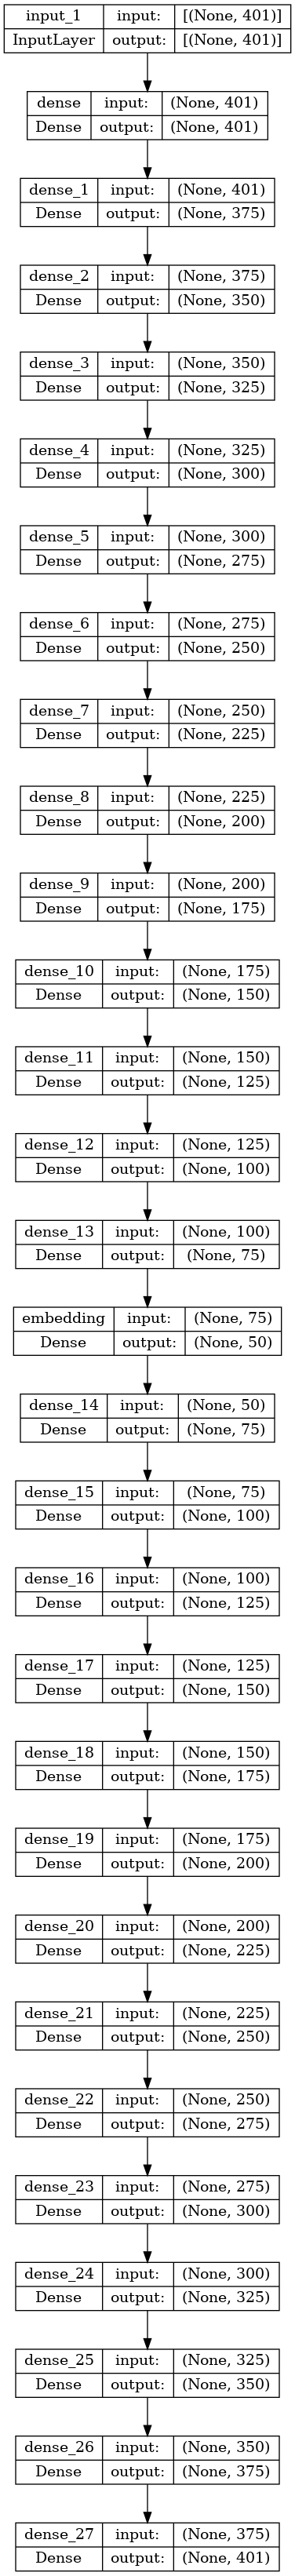

In [ ]:
plot_model(autoencoder, show_shapes=True, show_layer_names=True, to_file='autoencoder.png')

In [ ]:
autoencoder.compile(loss='mae', optimizer='adam')
callback = EarlyStopping(monitor='loss', patience=3)

history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.1, #shuffle=False, 
                callbacks=[callback], validation_data = (X_test, X_test))

Epoch 1/100
108/108 [==============================] - 3s 9ms/step - loss: 0.1177 - val_loss: 0.0901
Epoch 2/100
108/108 [==============================] - 1s 6ms/step - loss: 0.0894 - val_loss: 0.0896
Epoch 3/100
108/108 [==============================] - 1s 6ms/step - loss: 0.0891 - val_loss: 0.0891
Epoch 4/100
108/108 [==============================] - 1s 6ms/step - loss: 0.0887 - val_loss: 0.0890
Epoch 5/100
108/108 [==============================] - 1s 7ms/step - loss: 0.0871 - val_loss: 0.0857
Epoch 6/100
108/108 [==============================] - 1s 6ms/step - loss: 0.0852 - val_loss: 0.0852
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 0.0848 - val_loss: 0.0851
Epoch 8/100
108/108 [==============================] - 1s 6ms/step - loss: 0.0847 - val_loss: 0.0851
Epoch 9/100
108/108 [==============================] - 1s 6ms/step - loss: 0.0846 - val_loss: 0.0851
Epoch 10/100
108/108 [==============================] - 1s 6ms/step - loss: 0.0845 - val_lo

In [ ]:
emb_dim = 50
input = tf.keras.layers.Input(shape=X_train.shape[1:])

encoder = tf.keras.layers.Dense(X_train.shape[1:][0], activation='relu')(input)
encoder = tf.keras.layers.Dense(350, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(300, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(250, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(200, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(150, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(100, activation='relu')(encoder)
embedding = tf.keras.layers.Dense(emb_dim, activation='relu',name='embedding')(encoder)

decoder = tf.keras.layers.Dense(100, activation='relu')(embedding)
decoder = tf.keras.layers.Dense(150, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(200, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(250, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(300, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(350, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(X_train.shape[1], activation='sigmoid')(decoder),

autoencoder = Model(input, decoder)
autoencoder.summary()

autoencoder.compile(loss='mae', optimizer='adam')
callback = EarlyStopping(monitor='loss', patience=3)

history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.1, #shuffle=False, 
                callbacks=[callback], validation_data = (X_test, X_test))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 401)]             0         
                                                                 
 dense_28 (Dense)            (None, 401)               161202    
                                                                 
 dense_29 (Dense)            (None, 350)               140700    
                                                                 
 dense_30 (Dense)            (None, 300)               105300    
                                                                 
 dense_31 (Dense)            (None, 250)               75250     
                                                                 
 dense_32 (Dense)            (None, 200)               50200     
                                                                 
 dense_33 (Dense)            (None, 150)               3015

In [ ]:
team_embedding = Model(input, embedding)

In [ ]:
svd4 = TruncatedSVD(n_components=30, n_iter=20, random_state=42)
all_teams_reduced30 = svd4.fit_transform(teamscaler.fit_transform(all_teams_df))
svd5 = TruncatedSVD(n_components=40, n_iter=20, random_state=42)
all_teams_reduced40 = svd5.fit_transform(teamscaler.fit_transform(all_teams_df))
svd6 = TruncatedSVD(n_components=50, n_iter=20, random_state=42)
all_teams_reduced50 = svd6.fit_transform(teamscaler.fit_transform(all_teams_df))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklea

In [ ]:
#Change the team embedding (all_teams_reduced50) if another SVD model is used (1 change needed)
#Combine the team embedding with team and season details
all_teams_reduced_df = pd.DataFrame(all_teams_reduced50)
teams = teams.reset_index()
team_embedding = pd.concat([teams['team'], all_teams_reduced_df], axis = 1)

def get_season(team):
    return team[-4:]
team_embedding['season']  = team_embedding.apply(lambda x: get_season(x['team']), axis=1)

team_embedding

,team,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,season
0,Northampton Town1617,6.673525,-0.735423,-0.253450,-0.455285,0.136386,-0.100403,0.151246,0.500671,0.172522,-0.162225,0.176343,0.364252,-0.502302,0.226609,-0.306469,0.237646,-0.071721,0.117726,-0.217372,-0.213855,0.160250,-0.276508,-0.142317,0.462892,0.103111,0.028777,-0.276291,-0.113859,0.198525,-0.105572,0.118259,-0.230348,0.072214,0.031082,-0.366070,0.107808,0.068962,-0.230587,-0.501200,0.016035,0.097839,-0.064538,-0.254727,0.278472,0.177036,-0.044551,-0.149865,0.315072,-0.064078,0.068532,1617
1,Malmö FF1920,7.029869,0.205871,-0.041170,0.754764,-0.009875,0.540898,0.066113,0.598244,0.400184,-0.149236,-0.385715,-0.335705,-0.045481,0.064279,-0.202032,-0.238551,-0.103790,-0.158989,0.216006,0.102014,-0.303673,0.025037,0.013374,-0.013203,-0.029791,0.062685,-0.048056,-0.115973,0.108339,-0.266865,0.402980,0.037142,-0.639363,-0.122741,0.426880,-0.383108,0.120145,0.219432,-0.226001,0.127134,0.089780,-0.068032,0.511105,-0.108979,0.070277,0.191556,-0.004047,-0.164952,0.023111,-0.260167,1920
2,Stevenage1819,6.656173,-1.115973,0.241513,0.627654,0.341820,-0.266877,-0.373107,-0.008936,0.066207,0.628529,-0.003475,-0.139512,-0.081250,-0.139409,-0.799983,-0.099392,0.022523,-0.203603,-0.125391,-0.171042,0.066904,0.191159,-0.435394,0.041075,0.097708,-0.045440,0.131915,-0.078537,-0.096643,-0.120808,-0.101259,0.049239,0.189281,-0.217397,0.009253,-0.054502,0.334307,-0.548630,-0.132253,0.111812,0.276081,-0.045641,0.106809,0.424303,-0.095087,0.159700,0.262935,0.222352,-0.349208,-0.184111,1819
3,Gimnàstic de Tarragona1516,6.872503,-0.305787,0.050975,0.245854,0.172671,-0.649907,-0.243495,0.323312,-0.043037,-0.127637,-0.413847,-0.190836,-0.452328,-0.090351,0.182036,0.348005,-0.332648,0.026299,0.080784,0.197843,0.139518,-0.134728,-0.593507,-0.149685,0.372799,0.720777,0.118954,-0.056845,-0.377345,0.252331,-0.339847,-0.371388,0.004562,0.185329,0.248003,-0.133897,0.015524,0.070829,-0.494766,-0.110737,0.233948,0.204813,-0.162437,-0.083336,-0.378847,-0.027844,-0.049102,0.101482,0.275568,0.111841,1516
4,Orlando City Soccer Club1819,7.332583,0.097049,1.031708,0.370685,-0.119968,-0.271251,-0.038709,0.389723,0.261428,0.258750,0.065454,-0.357773,0.210331,0.105984,-0.371478,-0.115021,0.101184,-0.344335,-0.134235,-0.037094,0.511377,0.094064,-0.002122,0.507754,-0.028444,-0.378250,0.031901,0.191241,0.291683,0.220279,0.052177,-0.246717,0.462199,0.415405,0.149587,-0.077456,0.288141,0.187705,0.174970,0.120249,-0.025306,0.284733,0.031151,-0.060892,-0.146301,-0.059553,-0.099316,0.212224,-0.370123,0.147463,1819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4062,Club Atlético Central Córdoba2021,7.123216,-0.244346,0.397483,0.744053,0.027180,0.301363,-0.000783,0.318173,0.064323,0.035899,0.626459,-0.546907,0.006406,-0.326792,0.148366,-0.011507,-0.010567,-0.485200,0.185900,-0.079243,0.057220,0.016500,0.254801,0.448409,-0.433902,-0.179766,-0.117061,-0.296471,-0.111390,0.083570,-0.215406,0.423138,0.150276,0.209293,0.004874,0.314622,-0.008871,0.033259,0.212266,0.229510,0.165840,0.097120,-0.389058,0.034460,-0.123905,-0.011885,-0.083659,0.016461,0.306242,0.165600,2021
4063,Al Hazem2122,6.481045,-0.740438,0.148771,-0.369372,0.530906,-0.272963,0.295589,0.210066,-0.118863,-0.156863,-0.061897,-0.088184,-0.397307,0.243621,-0.310306,-0.018171,0.055232,0.155397,-0.211345,-0.042409,-0.019777,0.136305,0.257164,-0.382681,-0.388262,-0.035710,-0.304093,-0.184648,0.230950,0.255242,0.249623,0.230050,-0.007821,0.431753,0.251410,0.265766,0.303090,0.122044,0.006080,0.050255,0.123538,0.195767,-0.117281,0.123583,-0.076455,-0.278635,-0.226928,-0.158087,0.514461,-0.004224,2122
4064,Türkgücü München2122,6.802913,-0.575260,0.452361,-0.232566,-0.221835,0.221272,-0.070405,0.453483,0.320424,0.2

**Team search (for cosine similarity and Euclidean distance)**
- Enter the team name for variable team_keyword in the following cell
- Get the row index (the leftmost column), then enter it as row_id_team in the next cell

In [ ]:
#Search team, just enter the keyword
team_keyword = "Manchester City"

team_embedding[team_embedding['team'].str.contains(team_keyword)][['team']]

,team
999,Manchester City1516
1140,Manchester City1415
1406,Manchester City1920
1411,Manchester City2122
1863,Manchester City1617
2083,Manchester City2021
3501,Manchester City1718
3523,Manchester City1819


In [ ]:
#Just enter the row index from the table above as row_id_team and run all other cells below
row_id_team = 2342

In [ ]:
#Cosine similarity
season = team_embedding.iloc[row_id_team]['team'][-4:]
team_embedding['cos_similarity']= cosine_similarity(all_teams_reduced_df.iloc[row_id_team:row_id_team+1], all_teams_reduced_df).tolist()[0]

In [ ]:
#team_embedding[team_embedding['team'].str.contains(team_keyword)][['team','cos_similarity']]

In [ ]:
#All teams
team_embedding[['team', 'cos_similarity']].sort_values(by='cos_similarity', ascending=False).iloc[1:].head(20)

,team,cos_similarity
68,Ajax1920,0.972451
2929,Hellas Verona1920,0.970451
2354,Hellas Verona2021,0.968587
2869,Real Sociedad2021,0.966658
3532,Vélez Sarsfield1920,0.966338
66,Everton1516,0.966269
1136,Leicester City1415,0.966074
2336,CD Tenerife2021,0.966045
3411,1. FC Union Berlin1819,0.965755
660,Al Nassr2122,0.965643


In [ ]:
#Only for teams in the same season
team_embedding[team_embedding['season']==season][['team', 'cos_similarity']].sort_values(by='cos_similarity', ascending=False).iloc[1:].head(20)

,team,cos_similarity
660,Al Nassr2122,0.965643
2833,Eintracht Frankfurt2122,0.964568
2810,VfB Stuttgart2122,0.963428
1438,Shimizu S-Pulse2122,0.962322
3244,Real Sociedad2122,0.962146
4038,Leeds United2122,0.961728
50,Tottenham Hotspur2122,0.961655
142,PAOK2122,0.961439
275,Everton2122,0.961379
285,Leicester City2122,0.960982


In [ ]:
#Euclidean distance, change the team embedding (all_teams_reduced50) if another SVD model is used (2 changes needed)
distance_team = []
for team_reduced in all_teams_reduced50:
    dist = np.linalg.norm(all_teams_reduced50[row_id_team] - team_reduced)
    distance_team.append(dist)
team_embedding['distance'] = distance_team

#All teams
team_embedding[['team', 'distance']].sort_values(by='distance', ascending=True).iloc[1:].head(20)

,team,distance
2929,Hellas Verona1920,1.840560
2354,Hellas Verona2021,1.897153
68,Ajax1920,1.901164
1136,Leicester City1415,1.964734
2336,CD Tenerife2021,1.966732
3411,1. FC Union Berlin1819,1.972935
66,Everton1516,1.985709
3532,Vélez Sarsfield1920,2.003967
660,Al Nassr2122,2.018567
3789,SK Slavia Praha1920,2.020695


In [ ]:
#Only for teams in the same season
team_embedding[team_embedding['season']==season][['team', 'distance']].sort_values(by='distance', ascending=True).iloc[1:].head(20)

,team,distance
660,Al Nassr2122,2.018567
142,PAOK2122,2.099080
2810,VfB Stuttgart2122,2.104287
2055,Argentinos Juniors2122,2.122706
3378,AEK Athens2122,2.126888
657,CD Tenerife2122,2.132195
3023,Inter Miami CF2122,2.133582
2833,Eintracht Frankfurt2122,2.139232
1104,Guangzhou FC2122,2.147117
1147,Sheffield United2122,2.164359


In [ ]:
team_embedding.to_csv('team_embedding.csv')
!zip team_embedding.csv.zip team_embedding.csv

updating: team_embedding.csv (deflated 54%)


In [ ]:
c = pd.DataFrame(svd6.inverse_transform(all_teams_reduced50))
d = teamscaler.fit_transform(all_teams_df).copy()
d = pd.DataFrame(d)

print('MAE of SVD for Team Embedding:')
abs(c-d).mean().mean()

MAE of SVD for Team Embedding:


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.05822202128957277